## **<font color=#10A1C4>*Необходимые библиотеки для модели</font>***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## **<font color=#10A1C4>*Реализация Модели</font>***

### **<font color=#10A1C4>*Загрузка котировок акций-голубых фишек российского рынка за последние полгода.</font>***


Так как модель Марковица требует не менее двух активов в портфеле, то возьмем для построения модели 3 акции 3 компаний. В качестве таковых мною были выбраны акции:
- Магнита; 
- Сбербанка;
- МТС. 

Во многом это был случайный выбор, но для чистоты эксперимента были взяты компании-представители из разных секторов для снижения корреляции между активами.


Начнем с чтения и обработки данных. Исторические котировки были выгружены с сайта InvestFunds (https://investfunds.ru/stocks/?auto=1&limit=30) c 11.11.2024  по 11.05.2025

In [20]:
mts = pd.read_excel('mobile-telesystems-mts-moscow-exchange.xlsx')
magnit = pd.read_excel('magnit-moscow-exchange.xlsx')
sberbank = pd.read_excel('sberbank-moscow-exchange.xlsx')

#Функция, которая оставляет столбцы "Дата" и "Цена Last"
def prepare_data(df, name):
    df = df[['Дата', 'Цена last']].copy()
    df.columns = ['Дата', name]
    df['Дата'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y', errors='coerce')
    return df.dropna()

mts = prepare_data(mts, 'MTS')
magnit = prepare_data(magnit, 'Magnit')
sberbank = prepare_data(sberbank, 'Sberbank')

#Здесь мы объединяем все в один датафрейм
data = mts.merge(magnit, on='Дата').merge(sberbank, on='Дата')
data = data.sort_values('Дата').set_index('Дата')
data.head()





,MTS,Magnit,Sberbank
Дата,,,
2024-11-11,203.75,4917.0,260.73
2024-11-12,197.60,4802.5,255.77
2024-11-13,198.35,4840.0,254.70
2024-11-14,195.80,4789.5,249.52
2024-11-15,198.15,4822.5,253.43


Мы преобразовали таблицы в один датафрейм, оставив только дату и цену акций 3 компаний

### **<font color=#10A1C4>*Корректировка на сплиты.</font>***


Так как впоследние полгода не производилось дроблений акций, то нет необходимости делать корректировки на сплиты. Но покажем как это в теории могло бы выглядеть:

In [21]:
#Создаем отдельную таблицу с корпоративными событиями (в нашем случае в ней будет находится всего 1 строчка: Сплит акций мтс с коэфициентом 1 1 февраля)
corp_actions = pd.DataFrame({
    'Компания': ['MTS'],
    'Дата': [pd.Timestamp('2025-02-01')],
    'Коэффициент сплита': [1]
})

#Функция, которая делит на коэфициент сплита цену акций до наступления корпоративного события
for idx, action in corp_actions.iterrows():
    company = action['Компания']
    date = action['Дата']
    ratio = action['Коэффициент сплита']
    data.loc[data.index < date, company] /= ratio


### **<font color=#10A1C4>*Mean-Variance Portfolio.</font>***


Получаем логарифмические доходности, годовые средние доходности и ковариационную матрицу.

In [22]:
returns = np.log(data / data.shift(1)).dropna()
returns.head()

# Годовые показатели (252 торговых дня)
mu = returns.mean() * 252 # Ожидаемая годовая доходность
cov= returns.cov() * 252 # Годовая ковариационная матрица

print(mu)
print(cov)

MTS         0.110167
Magnit     -0.259772
Sberbank    0.299632
dtype: float64
               MTS    Magnit  Sberbank
MTS       0.137864  0.085968  0.100559
Magnit    0.085968  0.137348  0.087444
Sberbank  0.100559  0.087444  0.105663


Найдем веса активов, минимизирующие дисперсию портфеля при условиях:  1) сумма весов = 1,  2) веса ≥ 0

In [24]:
# Функция, которая расчитывает доходности и риска портфеля
def portfolio_performance(weights, mu, cov):
    ret = np.dot(weights, mu)
    vol = np.sqrt(weights.T @ cov @ weights)
    return ret, vol

# Функция, которая ищет минимальную дисперсию
def min_variance_portfolio(mu, cov):
    n = len(mu)
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    bounds = [(0, 1)] * n
    init = np.ones(n) / n
    result = minimize(lambda w: w.T @ cov @ w,
                      x0=init,
                      bounds=bounds,
                      constraints=cons,
                      method='SLSQP')
    return result.x

# Расчитаем веса и их характеристики
weights = min_variance_portfolio(mu, cov)
port_ret, port_vol = portfolio_performance(weights, mu, cov)


print('Веса активов:')
for t, w in zip(mu.index, weights):
    print(f'{t}: {w:.2%}')
print(f'Ожидаемая доходность: {port_ret:.2%}')
print(f'Риск (волатильность): {port_vol:.2%}')

Веса активов:
MTS: 9.68%
Magnit: 26.22%
Sberbank: 64.10%
Ожидаемая доходность: 13.46%
Риск (волатильность): 31.68%


Построим график кумулятивной доходности сформированного портфеля

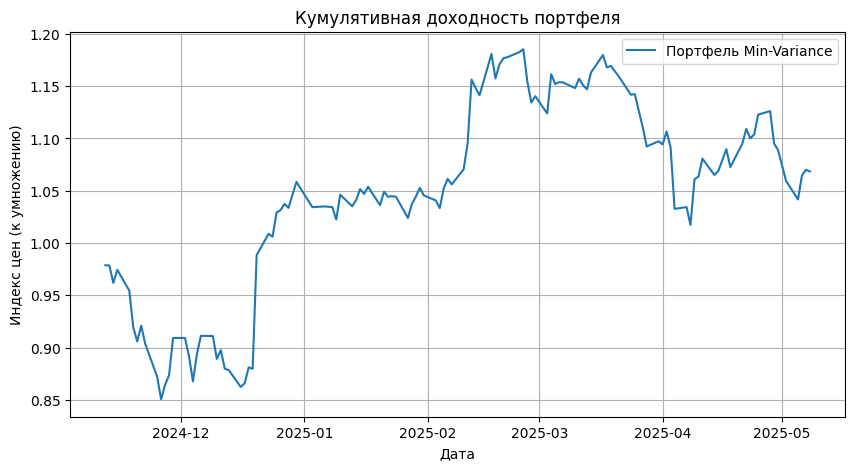

In [25]:
# Доходности портфеля
portfolio_returns = returns.dot(weights)

# Кумулятивная доходность
cumulative = np.exp(np.cumsum(portfolio_returns))

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(cumulative.index, cumulative, label='Портфель Min-Variance')
plt.title('Кумулятивная доходность портфеля')
plt.xlabel('Дата')
plt.ylabel('Индекс цен (к умножению)')
plt.legend()
plt.grid(True)
plt.show()